<a href="https://colab.research.google.com/github/jeramirez169/DataScience_SGS_Classification/blob/main/models/03_BETO_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clonar tu repositorio desde GitHub
!git clone https://github.com/jeramirez169/DataScience_SGS_Classification.git
%cd DataScience_SGS_Classification



fatal: destination path 'DataScience_SGS_Classification' already exists and is not an empty directory.
/content/DataScience_SGS_Classification


In [2]:
# Ir a la carpeta data
%cd data

# Descomprimir el archivo ZIP
!unzip "Dataset_SGS_clean.zip" -d .

# Regresar al directorio raíz del proyecto
%cd ..


/content/DataScience_SGS_Classification/data
Archive:  Dataset_SGS_clean.zip
replace ./Dataset_SGS_clean.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: /content/DataScience_SGS_Classification


In [4]:
import pandas as pd

# Carga del dataset limpio
ruta = "data/Dataset_SGS_clean.csv"   # Ajusta si tu ruta es distinta
df = pd.read_csv(ruta, encoding="utf-8")

print("Columnas del dataset:", df.columns.tolist())
print("Tamaño del dataset:", df.shape)
df.head()

Columnas del dataset: ['Oficina', 'texto_truncado', 'texto_truncado_lematizado']
Tamaño del dataset: (69746, 3)


,Oficina,texto_truncado,texto_truncado_lematizado
0,Operaciones,Sol -28-Noviembre-2025 08:00-11:00-Jose Fernan...,Sol -28-noviembre-2025 08:00-11:00-jose Fernan...
1,Multimedios,Sol -05-DIC-25 09:00-13:00-Marcela Botero Muño...,Sol -05-dic-25 09:00-13:00-marcela Botero Muño...
2,Operaciones,Sol -28-Noviembre-2025 14:00-17:00-Jose Fernan...,Sol -28-noviembre-2025 14:00-17:00-jo él Ferna...
3,Operaciones,Sol -26-Noviembre-2025 08:00-11:00-Jose Fernan...,Sol -26-noviembre-2025 08:00-11:00-jose Fernan...
4,Multimedios,Solicitud audifonos nueva gestora Valeria Toba...,Solicitud audifono gestora Valeria Tobar solic...


In [6]:
# CELDA 2: semillas + split 80/20

import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo en uso:", device)

# 1. Filtramos filas con texto y etiqueta no vacíos
df = df[df["texto_truncado"].notna() & (df["texto_truncado"].str.strip() != "")]
df = df[df["Oficina"].notna()].copy()

print("\nTamaño del dataset tras filtrado:", len(df))

# 2. Codificamos Oficina -> label_id entero
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["Oficina"])

print("\nMapeo Oficina -> id:")
for clase, codigo in zip(le.classes_, le.transform(le.classes_)):
    print(f"{clase:30s} -> {codigo}")

# 3. Definimos X (texto) e y (etiqueta numérica)
X = df["texto_truncado"].values
y = df["label_id"].values

# 4. Split 80 % train / 20 % test, estratificado por Oficina
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("\nTamaños finales:")
print("Train:", len(X_train))
print("Test: ", len(X_test))

# Distribución de clases para comprobar estratificación
import pandas as pd

train_df_tmp = pd.DataFrame({"text": X_train, "label": y_train})
test_df_tmp  = pd.DataFrame({"text": X_test,  "label": y_test})

print("\nDistribución de clases en TRAIN:")
print(train_df_tmp["label"].value_counts(normalize=True).sort_index())

print("\nDistribución de clases en TEST:")
print(test_df_tmp["label"].value_counts(normalize=True).sort_index())


Dispositivo en uso: cuda

Tamaño del dataset tras filtrado: 69746

Mapeo Oficina -> id:
Biblioteca                     -> 0
Desarrollo de sistemas         -> 1
Infraestructura                -> 2
Multimedios                    -> 3
Operaciones                    -> 4
Servicios y proyectos          -> 5

Tamaños finales:
Train: 55796
Test:  13950

Distribución de clases en TRAIN:
label
0    0.030307
1    0.093931
2    0.103466
3    0.443365
4    0.270700
5    0.058230
Name: proportion, dtype: float64

Distribución de clases en TEST:
label
0    0.030323
1    0.093907
2    0.103441
3    0.443369
4    0.270681
5    0.058280
Name: proportion, dtype: float64


In [8]:
# CELDA 3: Dataset de Hugging Face + tokenización con BETO

!pip install -q datasets

from datasets import Dataset
from transformers import AutoTokenizer
from IPython.display import display

# 1. Reconstruimos dataframes de train y test a partir de los arrays X_train, y_train, etc.
train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df  = pd.DataFrame({"text": X_test,  "label": y_test})

print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)
print("\ntrain_df.head():")
display(train_df.head())

# 2. Convertimos a Dataset de Hugging Face
hf_train = Dataset.from_pandas(train_df, preserve_index=False)
hf_test  = Dataset.from_pandas(test_df,  preserve_index=False)

print("\nHF train dataset:", hf_train)
print("HF test dataset:", hf_test)

# 3. Definimos hiperparámetros (ajusta estos valores para que coincidan con tu metodología)
HYPERPARAMS = {
    "model_name": "dccuchile/bert-base-spanish-wwm-cased",  # BETO Cased
    "max_length": 256,        # ajusta si en tu tesis definiste otro
    "learning_rate": 3e-5,    # idem
    "batch_size": 16,
    "num_epochs": 4,
    "warmup_ratio": 0.1
}

print("\nHiperparámetros actuales:")
for k, v in HYPERPARAMS.items():
    print(f"{k}: {v}")

# 4. Cargamos tokenizador de BETO
tokenizer = AutoTokenizer.from_pretrained(HYPERPARAMS["model_name"])

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=HYPERPARAMS["max_length"]
    )

# 5. Aplicamos tokenización a train y test
tokenized_train = hf_train.map(tokenize_batch, batched=True)
tokenized_test  = hf_test.map(tokenize_batch,  batched=True)

# 6. Hugging Face Trainer espera la columna "labels"
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test  = tokenized_test.rename_column("label", "labels")

# 7. Formato tensor para usar con PyTorch
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print("\nColumnas en tokenized_train:", tokenized_train.column_names)
print("Columnas en tokenized_test:", tokenized_test.column_names)

print("\nEjemplo de un registro tokenizado (train[0]) (mostramos tipos/shapes):")
example = tokenized_train[0]
for k, v in example.items():
    if hasattr(v, "shape"):
        print(f"{k}: shape={tuple(v.shape)}")
    else:
        print(f"{k}: {v}")


train_df shape: (55796, 2)
test_df shape: (13950, 2)

train_df.head():


,text,label
0,Préstamo de Elementos Multimediales : Taller 1...,3
1,Convenios Oracle Buen día Requiero información...,4
2,FORMATO DE PAZ Y SALVOS - Valeria Galvis Orozc...,4
3,Sol -12-MAY-25 14:00-18:00-Paula Andrea Ceron ...,3
4,Sol -02-NOV-24 15:00-17:00-Maria Isabel Rivas ...,3



HF train dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 55796
})
HF test dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 13950
})

Hiperparámetros actuales:
model_name: dccuchile/bert-base-spanish-wwm-cased
max_length: 256
learning_rate: 3e-05
batch_size: 16
num_epochs: 4
warmup_ratio: 0.1


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/55796 [00:00<?, ? examples/s]

Map:   0%|          | 0/13950 [00:00<?, ? examples/s]


Columnas en tokenized_train: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']
Columnas en tokenized_test: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']

Ejemplo de un registro tokenizado (train[0]) (mostramos tipos/shapes):
labels: shape=()
input_ids: shape=(256,)
attention_mask: shape=(256,)


In [9]:
# CELDA 4: modelo BETO + pesos de clase

from transformers import AutoConfig, AutoModelForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight

num_labels = len(le.classes_)
print("Número de etiquetas (Oficinas):", num_labels)
print("Clases:", list(le.classes_))

# Configuración del modelo BETO para clasificación
config = AutoConfig.from_pretrained(
    HYPERPARAMS["model_name"],
    num_labels=num_labels,
    id2label={i: cls for i, cls in enumerate(le.classes_)},
    label2id={cls: i for i, cls in enumerate(le.classes_)}
)

model = AutoModelForSequenceClassification.from_pretrained(
    HYPERPARAMS["model_name"],
    config=config
).to(device)

print("\nModelo cargado en dispositivo:", device)

# Cálculo de pesos por clase para manejar desbalance
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
).astype(np.float32)

print("\nPesos por clase (id -> peso):")
for i, w in enumerate(class_weights):
    print(f"id {i} ({le.inverse_transform([i])[0]}): {w:.4f}")


Número de etiquetas (Oficinas): 6
Clases: ['Biblioteca', 'Desarrollo de sistemas', 'Infraestructura', 'Multimedios', 'Operaciones', 'Servicios y proyectos']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Modelo cargado en dispositivo: cuda

Pesos por clase (id -> peso):
id 0 (Biblioteca): 5.4993
id 1 (Desarrollo de sistemas): 1.7743
id 2 (Infraestructura): 1.6108
id 3 (Multimedios): 0.3759
id 4 (Operaciones): 0.6157
id 5 (Servicios y proyectos): 2.8622


In [12]:
# CELDA 5: ENTRENAMIENTO BETO CON PESOS DE CLASE

from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn as nn
import torch
import math

# Data collator para padding por batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer con pérdida ponderada
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        self.class_weights = class_weights
        super().__init__(*args, **kwargs)
        if self.class_weights is not None:
            self.class_weights = torch.tensor(self.class_weights, dtype=torch.float32)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )
        logits = outputs.get("logits")

        if self.class_weights is not None:
            if self.class_weights.device != logits.device:
                self.class_weights = self.class_weights.to(logits.device)
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Métricas (las usaremos más adelante en test)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc  = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)
    macro_p  = precision_score(labels, preds, average="macro", zero_division=0)
    macro_r  = recall_score(labels, preds, average="macro", zero_division=0)
    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "macro_precision": macro_p,
        "macro_recall": macro_r,
    }

# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="runs/BETO_oficina_debug",
    learning_rate=HYPERPARAMS["learning_rate"],
    per_device_train_batch_size=HYPERPARAMS["batch_size"],
    per_device_eval_batch_size=HYPERPARAMS["batch_size"],
    num_train_epochs=HYPERPARAMS["num_epochs"],
    weight_decay=0.01,
    warmup_ratio=HYPERPARAMS["warmup_ratio"],
    logging_dir="runs/BETO_oficina_debug/logs",
    logging_steps=200,
    fp16=True,
    seed=42,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    tokenizer=tokenizer,
    data_collator=data_collator,
    class_weights=class_weights,
    compute_metrics=compute_metrics,
)

# ENTRENAMIENTO
train_result = trainer.train()

print("\nEntrenamiento finalizado.")
print("Global step (nº de pasos de optimización):", trainer.state.global_step)
print("Épocas completadas:", trainer.state.epoch)

expected_steps = math.ceil(len(tokenized_train) / HYPERPARAMS["batch_size"]) * HYPERPARAMS["num_epochs"]
print("Pasos esperados (aprox.):", expected_steps)


/tmp/ipython-input-1832420456.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
200,1.678100
400,1.110900
600,0.658000
800,0.525100
1000,0.458800
1200,0.398000
1400,0.442600
1600,0.389500
1800,0.424200
2000,0.415100



Entrenamiento finalizado.
Global step (nº de pasos de optimización): 13952
Épocas completadas: 4.0
Pasos esperados (aprox.): 13952


Métricas agregadas (test 20 %):
{'accuracy': 0.9201433691756272, 'macro_f1': 0.8799535145364167, 'macro_precision': 0.8728909116946529, 'macro_recall': 0.9001570581351895}

Classification report por Oficina:
                        precision    recall  f1-score   support

            Biblioteca       0.97      0.96      0.97       423
Desarrollo de sistemas       0.93      0.85      0.89      1310
       Infraestructura       0.79      0.80      0.79      1443
           Multimedios       0.99      0.99      0.99      6185
           Operaciones       0.95      0.86      0.90      3776
 Servicios y proyectos       0.61      0.94      0.74       813

              accuracy                           0.92     13950
             macro avg       0.87      0.90      0.88     13950
          weighted avg       0.93      0.92      0.92     13950


Matriz de confusión:
[[ 406    3    1    4    8    1]
 [   0 1108   14    4   18  166]
 [   1   20 1153    3  118  148]
 [   3    4    4 6148   26  

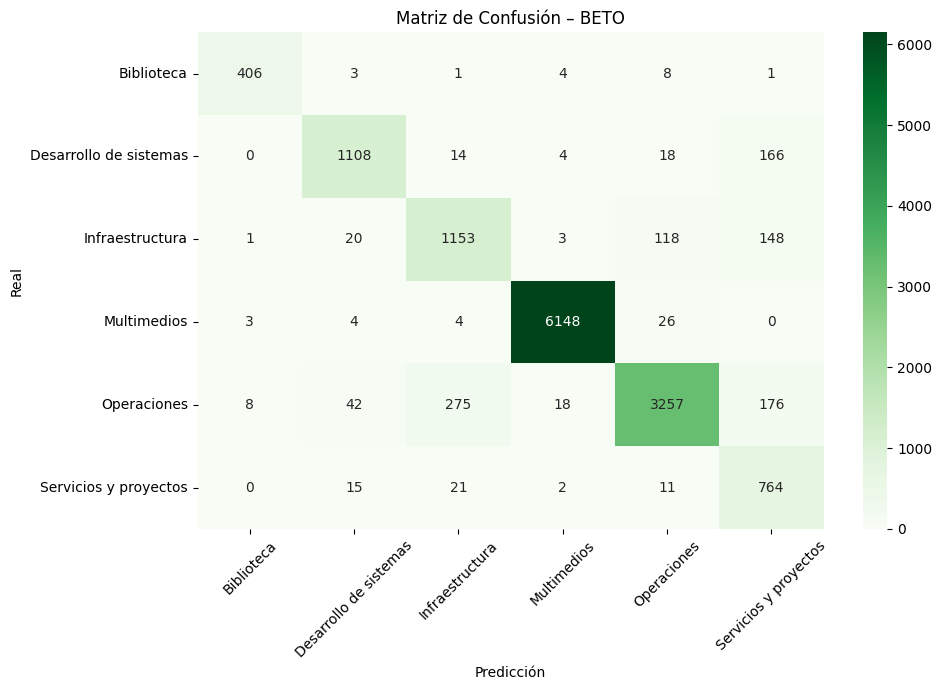

In [17]:
from transformers import Trainer
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Trainer estándar solo para evaluación (no entrena, solo predice)
eval_trainer = Trainer(
    model=trainer.model,      # modelo ya entrenado
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Predicción sobre el conjunto de test
predictions = eval_trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("Métricas agregadas (test 20 %):")
print(compute_metrics((predictions.predictions, y_true)))

print("\nClassification report por Oficina:")
print(classification_report(
    y_true, y_pred,
    target_names=le.classes_,
    zero_division=0
))

# Etiquetas con nombres de oficinas
labels = le.classes_

# Matriz de confusión BETO
cm_beto = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm_beto, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusión – BETO")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
